# **Logistische Regression**

Dieses Notebook behandelt die **logistische Regression** anhand eines einfachen Beispiels:

1. Was ist der Unterschied zu linearer Regression?
2. Künstliche Daten: `Lernzeit → Prüfung bestanden (ja/nein)`
3. Wie kann der Computer eine **Kurve** finden, die die Wahrscheinlichkeit fürs Bestehen beschreibt?
4. Interaktive Grafiken:
   - Ab wie vielen Stunden würdest **du** „bestanden“ sagen?
   - Wie sieht die **Wahrscheinlichkeit** fürs Bestehen aus?
5. Aufgaben


In [1]:
# Bibliotheken laden
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from ipywidgets import interact, FloatSlider

# In einem Jupyter-/Colab-Notebook sorgt das dafür,
# dass die Grafiken direkt unter der Zelle angezeigt werden.
%matplotlib inline


## 1. Künstliche Beispieldaten erzeugen

Wir betrachten wieder eine Prüfung.

- **x-Achse**: Lernzeit in Stunden (0 bis 5 Stunden)
- **y-Wert**: Hat die Person bestanden?

Wir vereinfachen:
- `y = 1` → Prüfung **bestanden**
- `y = 0` → Prüfung **nicht bestanden**

Je mehr man lernt, desto **grösser** soll die Wahrscheinlichkeit fürs Bestehen werden.


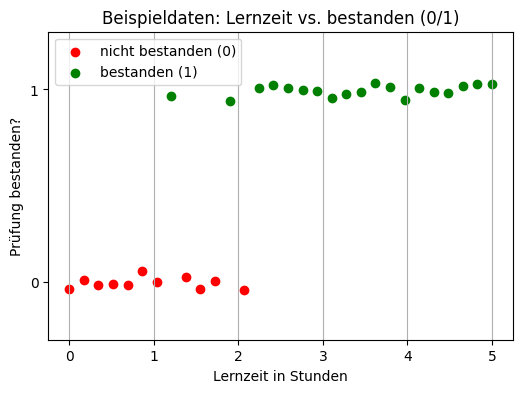

In [2]:
# Zufällige, aber reproduzierbare Daten erzeugen
np.random.seed(42)

# Lernzeit in Stunden
X = np.linspace(0, 5, 30)  # 30 Werte von 0 bis 5 Stunden
X_2d = X.reshape(-1, 1)

# "versteckte" wahre Beziehung:
# Bei 0 Stunden sehr kleine Chance, bei 5 Stunden sehr hohe Chance.
# Wir bauen uns eine S-Kurve (Sigmoid) im Hintergrund.
true_slope = 2.0       # wie stark beeinflussen Stunden die Chance zu bestehen?
true_intercept = -4.0  # verschiebt die Kurve nach links/rechts

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Wahrscheinlichkeiten fürs Bestehen
p_pass = sigmoid(true_slope * X + true_intercept)

# Jetzt würfeln wir für jede Person, ob sie besteht (1) oder nicht (0)
y = np.random.binomial(1, p_pass)

# Für die Visualisierung geben wir den Punkten leichte vertikale "Jitter"
y_plot = y + np.random.normal(0, 0.03, size=y.shape)

plt.figure(figsize=(6, 4))
plt.scatter(X[y==0], y_plot[y==0], color="red", label="nicht bestanden (0)")
plt.scatter(X[y==1], y_plot[y==1], color="green", label="bestanden (1)")
plt.yticks([0, 1])
plt.xlabel("Lernzeit in Stunden")
plt.ylabel("Prüfung bestanden?")
plt.title("Beispieldaten: Lernzeit vs. bestanden (0/1)")
plt.grid(True, axis="x")
plt.legend()
plt.ylim(-0.3, 1.3)
plt.show()


## 2. Idee der logistischen Regression

Bei der **linearen Regression** haben wir eine **Gerade** gesucht:  
> `y = m · x + b`

Bei einer Ja/Nein-Frage (bestanden / nicht bestanden) wäre eine solche Gerade **ungeeignet**, denn:

- Werte können unter 0 oder über 1 gehen
- Wir brauchen etwas wie eine **Wahrscheinlichkeit** für das Bestehen (zwischen 0 und 1)

Die logistische Regression macht genau das:

> Sie sagt zu jedem x (z. B. *3 Stunden Lernen*)  
> **„Wie gross ist die Wahrscheinlichkeit, dass die Person besteht?“**

Die Form ist eine **S-Kurve (Sigmoid)**:

- links: Wahrscheinlichkeit nahe 0 (fast sicher nicht bestanden)
- in der Mitte: Übergangsbereich
- rechts: Wahrscheinlichkeit nahe 1 (fast sicher bestanden)

Der Computer sucht wieder zwei Zahlen (ähnlich wie m und b), aber wir verstecken die komplizierte Formel und benutzen `scikit-learn`.


Geschätzte Parameter (intern im Modell):
  Steigung m ~ 1.798
  Achsenabschnitt b ~ -3.225


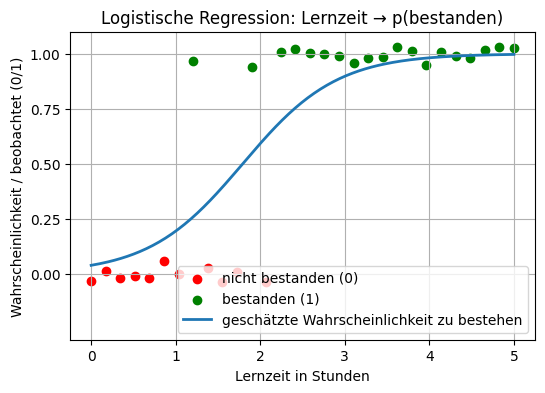

In [3]:
# Modell für logistische Regression trainieren
modell_log = LogisticRegression()
modell_log.fit(X_2d, y)

m_schaetzung = modell_log.coef_[0][0]   # "Steigung" im inneren linearen Teil
b_schaetzung = modell_log.intercept_[0] # "Achsenabschnitt" im inneren linearen Teil

print("Geschätzte Parameter (intern im Modell):")
print("  Steigung m ~", round(m_schaetzung, 3))
print("  Achsenabschnitt b ~", round(b_schaetzung, 3))

# Vorhersagewahrscheinlichkeiten auf einem feineren Gitter
X_fein = np.linspace(0, 5, 200).reshape(-1, 1)
p_vorhersage = modell_log.predict_proba(X_fein)[:, 1]

plt.figure(figsize=(6,4))
# Datenpunkte (0/1)
plt.scatter(X[y==0], y_plot[y==0], color="red", label="nicht bestanden (0)")
plt.scatter(X[y==1], y_plot[y==1], color="green", label="bestanden (1)")

# Wahrscheinlichkeitskurve
plt.plot(X_fein, p_vorhersage, label="geschätzte Wahrscheinlichkeit zu bestehen", linewidth=2)

plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel("Lernzeit in Stunden")
plt.ylabel("Wahrscheinlichkeit / beobachtet (0/1)")
plt.title("Logistische Regression: Lernzeit → p(bestanden)")
plt.grid(True)
plt.legend()
plt.ylim(-0.3, 1.1)
plt.show()


## 3. Interaktive Ansicht: „Ab wie vielen Stunden gilt: bestanden?“

Stell dir vor, du bist Lehrer:in und du entscheidest:

> „Wer **mindestens X Stunden** lernt, besteht.“

Wir stellen diese Entscheidungsgrenze als **vertikale Linie** dar.  
Du kannst mit einem Schieberegler einstellen, ab wie vielen Stunden **du** „bestanden“ sagen würdest und siehst:

- Welche Punkte wären nach deiner Regel **bestanden**?
- Welche **Fehler** machst du (z. B. jemand hat wenig gelernt, aber bestanden oder umgekehrt)?


In [4]:
def plot_threshold(grenze_stunden=2.5):
    plt.figure(figsize=(6,4))
    
    # Farben nach tatsächlichem Ergebnis
    colors = ["green" if yi == 1 else "red" for yi in y]
    labels = {0: "nicht bestanden (0)", 1: "bestanden (1)"}
    
    # Jitter für hübschere Darstellung
    plt.scatter(X, y_plot, c=colors)
    
    # Vertikale Entscheidungsgrenze
    plt.axvline(grenze_stunden, color="black", linestyle="--",
                label=f"Deine Grenze: ab {grenze_stunden:.2f} h = bestanden")
    
    # Deine Entscheidung nach Schwelle
    y_hat = (X >= grenze_stunden).astype(int)
    
    # Fehler zählen
    richtig = np.sum(y_hat == y)
    gesamt = len(y)
    genauigkeit = richtig / gesamt * 100
    
    plt.yticks([0, 1])
    plt.xlabel("Lernzeit in Stunden")
    plt.ylabel("Prüfung bestanden?")
    plt.title("Deine einfache Entscheidungsregel")
    plt.grid(True, axis="x")
    plt.ylim(-0.3, 1.3)
    plt.legend()
    plt.show()
    
    print(f"Mit deiner Grenze bei {grenze_stunden:.2f} Stunden:")
    print(f" - Richtig klassifizierte Personen: {richtig} von {gesamt}")
    print(f" - Genauigkeit: {genauigkeit:.1f} %")
    print("Hinweis: Das ist eine einfache Schwellen-Regel – noch keine Statistik 😊")

interact(
    plot_threshold,
    grenze_stunden=FloatSlider(value=2.5, min=0.0, max=5.0, step=0.1, description="Grenze (h)")
);


interactive(children=(FloatSlider(value=2.5, description='Grenze (h)', max=5.0), Output()), _dom_classes=('wid…

## 4. Interaktive Ansicht: Wahrscheinlichkeiten der logistischen Regression

Jetzt schauen wir auf das **gelerntes Modell** (die S-Kurve).

Du kannst eine Lernzeit auswählen und siehst:

- die **Wahrscheinlichkeit**, die das Modell fürs Bestehen schätzt
- eine horizontale Linie bei **50 %** → ab dort sagt das Modell: *„Ich tippe auf bestanden.“*


In [ ]:
def plot_logistic_with_point(stunden=2.5):
    plt.figure(figsize=(6,4))
    
    # Wahrscheinlichkeitskurve
    plt.plot(X_fein, p_vorhersage, linewidth=2, label="p(bestanden) laut Modell")
    
    # horizontale Linie bei 0.5
    plt.axhline(0.5, color="gray", linestyle="--", label="Grenze 0.5 (50%)")
    
    # gewählte Stunden und entsprechende Modell-Wahrscheinlichkeit
    p_stunden = modell_log.predict_proba([[stunden]])[0, 1]
    plt.axvline(stunden, color="black", linestyle="--")
    plt.scatter([stunden], [p_stunden], color="orange", zorder=5, label=f"dein Punkt ({stunden:.2f} h)")
    
    plt.xlabel("Lernzeit in Stunden")
    plt.ylabel("p(bestanden)")
    plt.title("Logistische Regression: Wahrscheinlichkeit fürs Bestehen")
    plt.ylim(-0.05, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print(f"Für {stunden:.2f} Stunden Lernzeit schätzt das Modell:")
    print(f"  p(bestanden) ≈ {p_stunden*100:.1f} %")
    if p_stunden >= 0.5:
        print("→ Nach der 50%-Regel würde das Modell sagen: BESTANDEN.")
    else:
        print("→ Nach der 50%-Regel würde das Modell sagen: NICHT BESTANDEN.")

interact(
    plot_logistic_with_point,
    stunden=FloatSlider(value=2.5, min=0.0, max=5.0, step=0.1, description="Stunden")
);


interactive(children=(FloatSlider(value=2.5, description='Stunden', max=5.0), Output()), _dom_classes=('widget…

## 5. Vorhersage mit dem Modell

Wie bei der linearen Regression können wir eine **konkrete Frage** stellen:

> „Was sagt das Modell für 3 Stunden Lernen?“

Wir erhalten:
- Eine **Wahrscheinlichkeit** zwischen 0 und 1
- Eine Entscheidung (0 oder 1), wenn wir z. B. bei 50 % die Grenze ziehen


In [6]:
stunden = 3.0
p_bestanden = modell_log.predict_proba([[stunden]])[0, 1]
entscheidung = modell_log.predict([[stunden]])[0]

print(f"Für {stunden} Stunden Lernzeit schätzt das Modell:")
print(f"  Wahrscheinlichkeit zu bestehen: {p_bestanden*100:.1f} %")
print(f"  Modell-Entscheidung (0 = nicht bestanden, 1 = bestanden): {entscheidung}")


Für 3.0 Stunden Lernzeit schätzt das Modell:
  Wahrscheinlichkeit zu bestehen: 89.8 %
  Modell-Entscheidung (0 = nicht bestanden, 1 = bestanden): 1


## 6. Aufgaben

Beantworte die folgenden Fragen **schriftlich** in einem separaten Dokument:

1. **Beobachtung der Daten**
   1. Schau dir den ersten Plot mit den 0/1-Punkten an.  
      Wie verändert sich ungefähr der Anteil der „bestanden“-Punkte, wenn die Lernzeit zunimmt?  
   2. Ist der Übergang eher abrupt (harte Grenze) oder weich (Übergangsbereich)?

2. **Entscheidungsgrenze in Stunden**
   1. Spiele mit dem Schieberegler in der ersten interaktiven Grafik.  
      Was passiert mit der Anzahl richtig klassifizierter Personen, wenn du die Grenze sehr tief setzt (z. B. 1 Stunde)?  
   2. Was passiert, wenn du die Grenze sehr hoch setzt (z. B. 4.5 Stunden)?  
   3. Beschreibe in eigenen Worten, warum eine **zu tiefe** oder **zu hohe** Grenze problematisch sein kann.

3. **Wahrscheinlichkeit verstehen**
   1. Wähle in der zweiten interaktiven Grafik verschiedene Stundenwerte (z. B. 1 h, 2.5 h, 4 h).  
      Wie verändert sich die geschätzte Wahrscheinlichkeit, dass man besteht?  
   2. Erkläre in einem Satz, was es bedeutet, wenn das Modell sagt:  
      *„p(bestanden) = 0.8 für 3 Stunden Lernen“*.

4. **Modell-Entscheidung**
   1. Warum ist es sinnvoll, eine Grenze bei 50 % zu setzen („ab hier tippt das Modell auf bestanden“)?  
   2. Überlege dir eine Situation, in der man eine **strengere** Grenze wählen würde (z. B. 70 %).

5. **Vergleich zur linearen Regression**
   1. Warum ist eine **lineare Regression** für Ja/Nein-Daten (0/1) nicht ideal?  
   2. Nenne einen Vorteil der logistischen Regression im Vergleich zur linearen Regression in diesem Beispiel.
6. **Kritische Überlegung**
   Nenne **zwei Gründe**, warum auch dieses Modell die Realität nur **ungefähr** beschreibt.  
   (Stichworte: andere Einflüsse als Lernzeit, Zufall, Messfehler, ...)
